In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'Consolidated_Prices (1).xlsx'  # update path if needed
df = pd.read_excel(file_path, sheet_name='Sheet1')

In [3]:
df = df[['Date', 'PVC', 'Polypropylene', 'Polyethilen', 'Brent']].copy()

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [5]:
for col in ['PVC', 'Polypropylene', 'Polyethilen', 'Brent']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
start_date = pd.to_datetime('2011-06-30')
df = df[df['Date'] >= start_date].copy()

In [7]:
print("Data after date filter:")
print(df.head())
print("Filtered shape:", df.shape)

Data after date filter:
          Date      PVC  Polypropylene  Polyethilen   Brent
175 2011-06-30  1285.83        1918.39      1788.99  113.83
174 2011-07-31  1218.88        1688.13      1587.98  116.97
173 2011-08-31  1176.30        1681.97      1621.00  110.22
172 2011-09-30  1107.51        1597.43      1545.68  112.83
171 2011-10-31  1071.09        1509.38      1509.38  109.55
Filtered shape: (176, 5)


In [8]:
for col in ['PVC', 'Polypropylene', 'Polyethilen', 'Brent']:
    df[col + '_ret'] = df[col].pct_change()

In [9]:
df_returns = df.dropna(subset=['PVC_ret', 'Polypropylene_ret', 'Polyethilen_ret', 'Brent_ret']).copy()
print("\nFirst 5 rows of RETURN data:")
print(df_returns.head())
print("Shape after returns:", df_returns.shape)


First 5 rows of RETURN data:
          Date      PVC  Polypropylene  Polyethilen   Brent   PVC_ret  \
174 2011-07-31  1218.88        1688.13      1587.98  116.97 -0.052068   
173 2011-08-31  1176.30        1681.97      1621.00  110.22 -0.034934   
172 2011-09-30  1107.51        1597.43      1545.68  112.83 -0.058480   
171 2011-10-31  1071.09        1509.38      1509.38  109.55 -0.032885   
170 2011-11-30   995.24        1402.85      1416.44  110.77 -0.070816   

     Polypropylene_ret  Polyethilen_ret  Brent_ret  
174          -0.120028        -0.112359   0.027585  
173          -0.003649         0.020794  -0.057707  
172          -0.050262        -0.046465   0.023680  
171          -0.055120        -0.023485  -0.029070  
170          -0.070579        -0.061575   0.011136  
Shape after returns: (172, 9)


In [10]:
def regress_returns(polymer_ret_name):
    sub = df_returns[['Brent_ret', polymer_ret_name]].dropna()
    X = sm.add_constant(sub['Brent_ret'])
    y = sub[polymer_ret_name]
    model = sm.OLS(y, X).fit()
    return model, len(sub)

In [11]:
results = []
for poly in ['PVC_ret', 'Polypropylene_ret', 'Polyethilen_ret']:
    model, n_obs = regress_returns(poly)
    results.append({
        'Polymer': poly.replace('_ret', ''),
        'R squared (returns)': model.rsquared,
        'Intercept': model.params['const'],
        'Beta (Brent return)': model.params['Brent_ret'],
        'p-value (beta)': model.pvalues['Brent_ret'],
        'Observations': n_obs
    })

In [12]:
print("\n" + "=" * 70)
print("REGRESSIONS Brent RETURNS as predictor (from 2011-06-30)")
print("=" * 70)
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))


REGRESSIONS Brent RETURNS as predictor (from 2011-06-30)
      Polymer  R squared (returns)  Intercept  Beta (Brent return)  p-value (beta)  Observations
          PVC             0.058156  -0.000840             0.116037    1.438409e-03           172
Polypropylene             0.106329  -0.002001             0.197379    1.269800e-05           172
  Polyethilen             0.138977  -0.001788             0.222834    4.746742e-07           172


Correlation matrix of returns


Correlation matrix of RETURNS (n = 172)
                   Brent_ret  PVC_ret  Polypropylene_ret  Polyethilen_ret
Brent_ret              1.000    0.241              0.326            0.373
PVC_ret                0.241    1.000              0.660            0.622
Polypropylene_ret      0.326    0.660              1.000            0.908
Polyethilen_ret        0.373    0.622              0.908            1.000


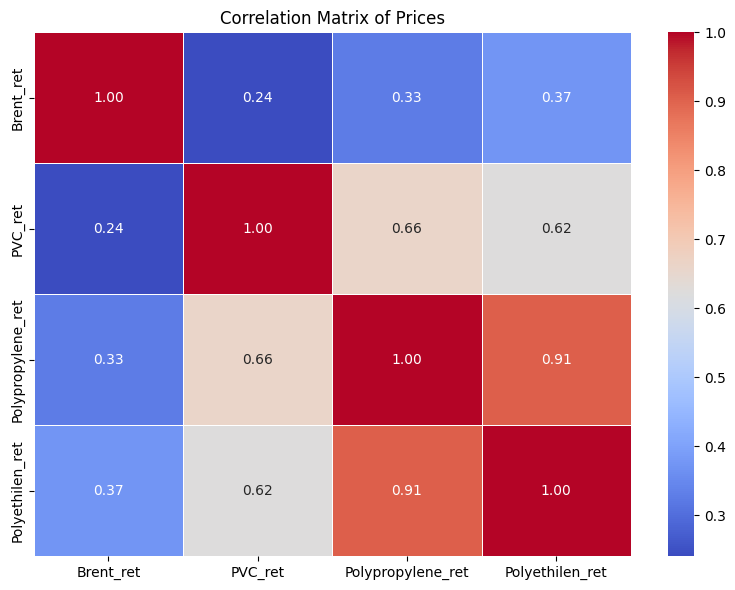

In [13]:
complete_returns = df_returns[['Brent_ret', 'PVC_ret', 'Polypropylene_ret', 'Polyethilen_ret']]
print("\n" + "=" * 70)
print(f"Correlation matrix of RETURNS (n = {len(complete_returns)})")
print("=" * 70)
print(complete_returns.corr().round(3))
# Plot and Save Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(complete_returns.corr().round(3), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Prices')
plt.tight_layout()
plt.show()

In [14]:
window = 12
rolling_betas = []

In [15]:
for i in range(window, len(df_returns) + 1):
    sub = df_returns.iloc[i - window:i]
    X = sm.add_constant(sub['Brent_ret'])
    y = sub['PVC_ret']
    model = sm.OLS(y, X).fit()
    rolling_betas.append(model.params['Brent_ret'])

In [16]:
rolling_beta_series = pd.Series(rolling_betas, index=df_returns.index[window - 1:])

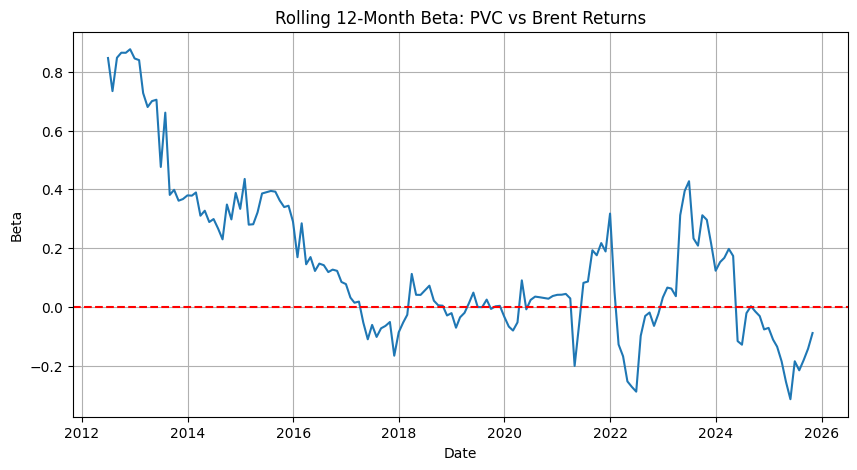

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df_returns['Date'][window - 1:], rolling_beta_series)
plt.axhline(0, linestyle='--', color='red')
plt.title('Rolling 12-Month Beta: PVC vs Brent Returns')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [18]:
print("\nRolling Beta Summary (PVC vs Brent):")
print(rolling_beta_series.describe())


Rolling Beta Summary (PVC vs Brent):
count    161.000000
mean       0.141783
std        0.260892
min       -0.314167
25%       -0.031024
50%        0.055930
75%        0.298778
max        0.876518
dtype: float64


In [19]:
df_price_clean = df.dropna(subset=['PVC', 'Polypropylene', 'Polyethilen', 'Brent']).copy()

In [20]:
models_config = [
    {'target': 'PVC', 'predictors': ['Brent', 'Polypropylene', 'Polyethilen']},
    {'target': 'Polyethilen', 'predictors': ['Brent', 'PVC', 'Polypropylene']},
    {'target': 'Polypropylene', 'predictors': ['Brent', 'PVC', 'Polyethilen']}
]


Regression Analysis for Target: PVC
Predictors: ['Brent', 'Polypropylene', 'Polyethilen']
                            OLS Regression Results                            
Dep. Variable:                    PVC   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     56.70
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           2.06e-25
Time:                        17:42:45   Log-Likelihood:                -1175.3
No. Observations:                 173   AIC:                             2359.
Df Residuals:                     169   BIC:                             2371.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

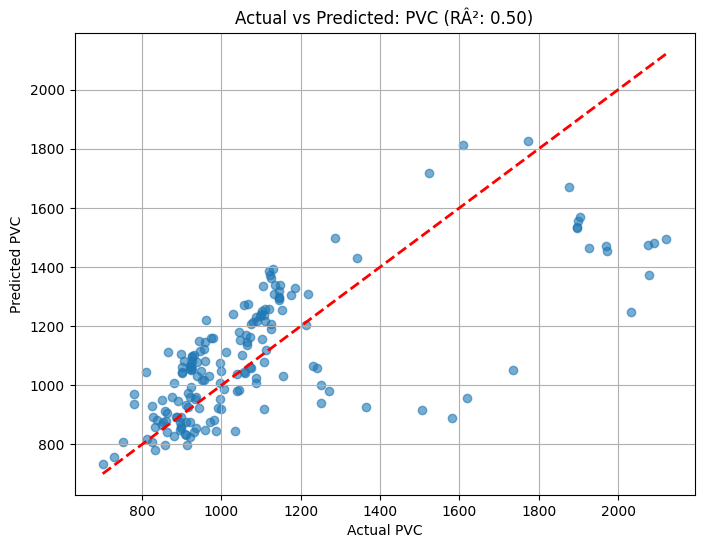


Regression Analysis for Target: Polyethilen
Predictors: ['Brent', 'PVC', 'Polypropylene']
                            OLS Regression Results                            
Dep. Variable:            Polyethilen   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     274.9
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           9.24e-65
Time:                        17:42:45   Log-Likelihood:                -1054.5
No. Observations:                 173   AIC:                             2117.
Df Residuals:                     169   BIC:                             2130.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

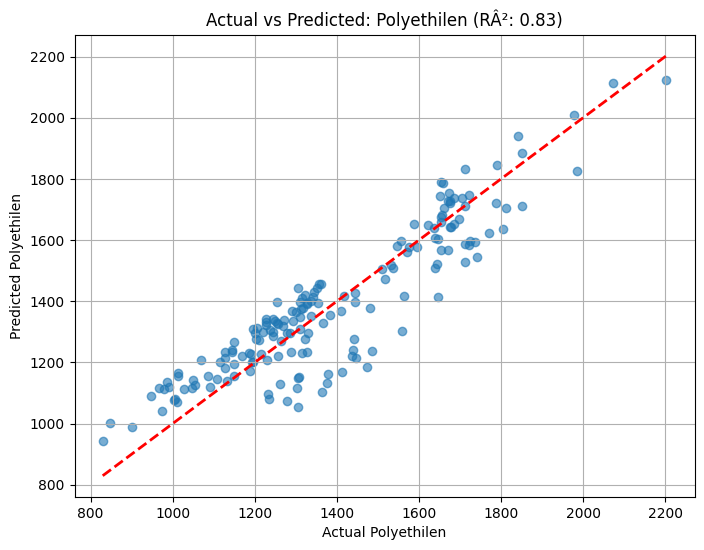


Regression Analysis for Target: Polypropylene
Predictors: ['Brent', 'PVC', 'Polyethilen']
                            OLS Regression Results                            
Dep. Variable:          Polypropylene   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     392.8
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           6.41e-76
Time:                        17:42:45   Log-Likelihood:                -1045.7
No. Observations:                 173   AIC:                             2099.
Df Residuals:                     169   BIC:                             2112.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

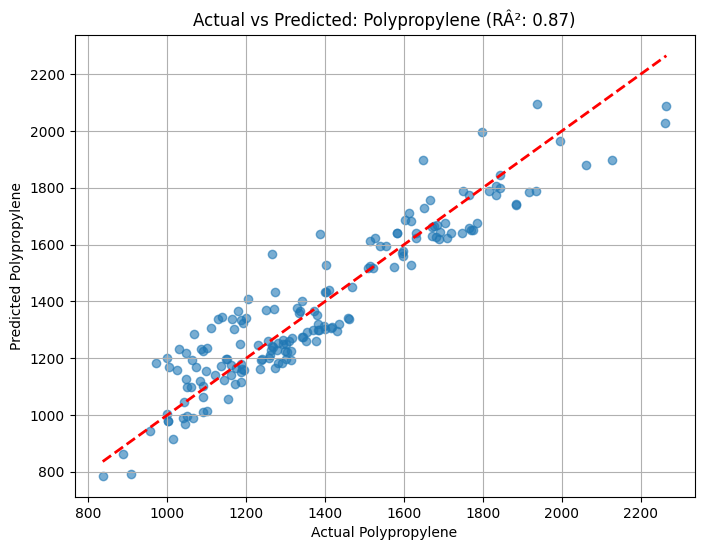

In [21]:
for config in models_config:
    target = config['target']
    predictors = config['predictors']
    Y = df_price_clean[target]
    X = df_price_clean[predictors]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    print("\n" + "=" * 60)
    print(f"Regression Analysis for Target: {target}")
    print(f"Predictors: {predictors}")
    print("=" * 60)
    print(model.summary())

    # Plot Actual vs Predicted
    predictions = model.predict(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(Y, predictions, alpha=0.6)
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2)  # identity line
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Actual vs Predicted: {target} (RÂ²: {model.rsquared:.2f})')
    plt.grid(True)
    plt.show()